# Protein Classification Challenge – Third Challenge

**Name:** AJ Book  
**Course:** EN.605.656.8VL – Computational Drug Discovery and Development  
**Due Date:** 04/21/2025  

---

This notebook continues the development of a complete machine learning pipeline for the **Protein Classification Challenge**, building upon the preprocessed dataset `metadata_org_w_features.csv` from earlier steps.

In this third phase, the focus is on model training and normalization strategies. The goal is to develop and compare multiple machine learning models—ranging from logistic regression to ensemble methods—while applying appropriate preprocessing techniques based on model assumptions and data characteristics.

This notebook includes the following core components:

- Modular extraction of biologically relevant feature blocks from the dataset  
- Construction of a clean, labeled dataset suitable for supervised learning  
- Application of various normalization techniques (StandardScaler, MinMaxScaler, RobustScaler)  
- Training and evaluation of multiple models including Logistic Regression, Random Forest, and MLP  
- Justification of when normalization is required and why it affects different models differently  
- Implementation of 10-fold cross-validation to assess generalization performance  
- Construction and evaluation of ensemble classifiers using bagging and soft voting  
- Output of predictions in a submission-ready format  


In [1]:
# Standard libraries for text processing, math, and data handling
import re
import numpy as np
import pandas as pd
from collections import Counter
import itertools

# BioPython for basic protein sequence analysis
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# scikit-learn: preprocessing, modeling, evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# Miscellaneous
import random
import matplotlib.pyplot as plt
import seaborn as sns


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Read in data that was generated from the analysis and preprocessing steps

In [2]:
# Read in data
data = pd.read_csv('metadata_org_w_features.csv')

# Information and sample data

In [3]:
# information on data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Columns: 589 entries, Entry to Gravy
dtypes: float64(584), int64(1), object(4)
memory usage: 3.1+ MB


In [4]:
# describe on data
data.describe()

,SequenceLength,A,C,D,E,F,G,H,I,K,...,DDD,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Flexibility,Helix,Sheet,Turn,Gravy
count,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,...,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000
mean,888.660793,0.071173,0.023348,0.044993,0.055845,0.046743,0.065586,0.022028,0.056255,0.047262,...,0.002206,99103.867857,7.097584,0.096863,42.160570,0.995021,0.304995,0.279123,0.389817,-0.051027
std,827.859592,0.022832,0.012300,0.013231,0.017925,0.015308,0.018840,0.007750,0.018204,0.017596,...,0.003108,92308.456460,1.551349,0.021673,7.412366,0.006859,0.029081,0.032611,0.043874,0.325872
min,103.000000,0.024283,0.000000,0.007605,0.005714,0.007782,0.016807,0.004065,0.009840,0.002915,...,0.000000,11710.270000,4.383673,0.033074,15.359896,0.974438,0.222539,0.183150,0.248630,-0.757339
25%,384.000000,0.056695,0.015251,0.037879,0.044280,0.035479,0.052764,0.016825,0.044171,0.034237,...,0.000000,42771.083500,5.723255,0.082587,37.259593,0.991538,0.284024,0.257261,0.361333,-0.284269
50%,676.000000,0.067460,0.021417,0.046046,0.058594,0.044747,0.065963,0.021544,0.056726,0.048017,...,0.001377,74697.663500,6.556855,0.094744,42.218182,0.996686,0.302326,0.277000,0.382857,-0.120350
75%,1015.000000,0.081784,0.030753,0.053254,0.067669,0.055838,0.078212,0.026769,0.068000,0.058943,...,0.003229,112207.097800,8.660054,0.109974,46.958534,0.999503,0.323615,0.300946,0.416667,0.136484
max,7096.000000,0.164000,0.074873,0.116598,0.123102,0.110701,0.153509,0.056093,0.125461,0.104956,...,0.031637,794048.925800,11.114366,0.180812,66.024733,1.013136,0.403005,0.419863,0.546125,1.008772


In [5]:
data.head()

,Entry,CleanSequence,Selected_PDB,ProteinClass,SequenceLength,A,C,D,E,F,...,DDD,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Flexibility,Helix,Sheet,Turn,Gravy
0,P21611,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...,3p73,MHC,119,0.109244,0.016807,0.058824,0.042017,0.058824,...,0.000000,13041.7928,5.834204,0.109244,22.404202,0.996347,0.336134,0.277311,0.369748,-0.047059
1,Q66GT5,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...,3rgo,Phosphatase,193,0.108808,0.015544,0.020725,0.067358,0.025907,...,0.000000,21942.2575,9.739448,0.082902,37.915078,0.992205,0.367876,0.186528,0.383420,-0.161140
2,Q9Y006,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,3qvc,Protease,451,0.028825,0.008869,0.048780,0.068736,0.079823,...,0.002227,51692.5641,8.043414,0.137472,37.618204,1.002078,0.305987,0.290466,0.434590,-0.249667
3,P05622,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...,1aya,RTK,1098,0.043716,0.017304,0.056466,0.069217,0.030055,...,0.003650,122788.2434,4.994010,0.083789,47.564763,0.999045,0.281421,0.311475,0.385246,-0.203097
4,P06343,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...,1d9k,MHC,263,0.041825,0.019011,0.022814,0.076046,0.038023,...,0.000000,29966.8989,8.991680,0.091255,46.750989,0.995690,0.262357,0.254753,0.399240,-0.303042


# Extract the relevant fields from the dataset

In [6]:
# Entry and ProteinClass
df = data.loc[:,['Entry', 'ProteinClass']]
# PDB
selected_PDB = data.loc[:,['Selected_PDB']]
# Sequence
seq = data.loc[:,['CleanSequence']]
# Sequence Length
seq_L = data.loc[:,['SequenceLength']]
# Amino Acid Frequencies
freq = data.iloc[:, 5 : 5+20]
# All possible dipeptide frequencies
dipep = data.iloc[:, 5+20 : 5+20 + 400]
# Reduced Amino Acid Alphabet Frequencies
red_freq = data.iloc[:, 5+20 + 400 : 5+20 + 400 + 5]
# N-Gram Profiles of Reduced Amino Acid Alphabet
red_ngram = data.iloc[:, 5+20 + 400 + 5 : 5+20 + 400 + 5 + 150]
# Protein Properties
prop = data.iloc[:, 5+20 + 400 + 5 + 150 :]

In [7]:
prop.head()

,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Flexibility,Helix,Sheet,Turn,Gravy
0,13041.7928,5.834204,0.109244,22.404202,0.996347,0.336134,0.277311,0.369748,-0.047059
1,21942.2575,9.739448,0.082902,37.915078,0.992205,0.367876,0.186528,0.383420,-0.161140
2,51692.5641,8.043414,0.137472,37.618204,1.002078,0.305987,0.290466,0.434590,-0.249667
3,122788.2434,4.994010,0.083789,47.564763,0.999045,0.281421,0.311475,0.385246,-0.203097
4,29966.8989,8.991680,0.091255,46.750989,0.995690,0.262357,0.254753,0.399240,-0.303042


# You can use this section if you wanted to add more features to the data

In [8]:
# Load original metadata into df_pfam
df_pfam = pd.read_csv("metadata_org_w_features.csv")

# Write out FASTA for Pfam scanning
with open("data/pfam/query.fasta", "w") as fh:
    for entry, seq in zip(df_pfam["Entry"], df_pfam["CleanSequence"]):
        fh.write(f">{entry}\n{seq}\n")


In [9]:
#!hmmscan --cpu 8 --domtblout data/pfam/domtblout.txt data/pfam/Pfam-A.hmm data/pfam/query.fasta > data/pfam/hmmscan.log

In [10]:
import pandas as pd
from pathlib import Path

def load_pfam(domtbl_path: Path, entries: pd.Series, e_cut: float = 1e-3) -> pd.DataFrame:
    rows = []
    with domtbl_path.open() as fh:
        for line in fh:
            if line.startswith("#"):
                continue
            parts = line.split()
            pfam_acc = parts[1]      # accession e.g. PF00001
            entry    = parts[3]
            evalue   = float(parts[12])
            if evalue <= e_cut:
                rows.append((entry, pfam_acc))
    hits = pd.DataFrame(rows, columns=["Entry","PfamAcc"])
    pfam_df = pd.crosstab(hits["Entry"], hits["PfamAcc"])
    # ensure every Entry appears
    pfam_df = pfam_df.reindex(entries.values, fill_value=0)
    pfam_df.index.name = "Entry"
    return pfam_df

# build and merge
df_pfam = pd.read_csv("metadata_org_w_features.csv")
pfam_df = load_pfam(Path("data/pfam/domtblout.txt"), df_pfam["Entry"])
pfam_df = pfam_df.reset_index()

df_merged = df_pfam.merge(pfam_df, on="Entry", how="left").fillna(0)

# redefine X, y
X = df_merged.drop(columns=["Entry","CleanSequence","Selected_PDB","ProteinClass"])
y = df_merged["ProteinClass"].astype(str)

# sanity check
pfam_cols = [c for c in X.columns if c.startswith("PF")]
print(f"Found {len(pfam_cols)} Pfam features. X shape: {X.shape}")
print("Examples:", pfam_cols[:10])


Found 454 Pfam features. X shape: (681, 1038)
Examples: ['PF', 'PF00001.24', 'PF00002.27', 'PF00003.25', 'PF00004.32', 'PF00005.30', 'PF00008.30', 'PF00017.27', 'PF00020.21', 'PF00023.33']


In [11]:
# === Step 1: Load the pre-selected top features ===
peptide_df = pd.read_csv("peptide_descriptors.csv")
protlearn_df = pd.read_csv("protlearn_features.csv")
scores_df = pd.read_csv("feature_scores_combined.csv")

# Clean all column names
peptide_df.columns = peptide_df.columns.str.strip()
protlearn_df.columns = protlearn_df.columns.str.strip()
scores_df.columns = scores_df.columns.str.strip()

# Extract top 50 PEP_ features and top 150 PL_ features by MeanScore
top_pep_features = scores_df[scores_df["Feature"].str.startswith("PEP_")] \
                    .sort_values("MeanScore", ascending=False) \
                    .head(50)["Feature"].str.strip().tolist()

top_pl_features = scores_df[scores_df["Feature"].str.startswith("PL_")] \
                   .sort_values("MeanScore", ascending=False) \
                   .head(150)["Feature"].str.strip().tolist()

# Select only the top features from each external block
peptide_df_selected = peptide_df[top_pep_features]
protlearn_df_selected = protlearn_df[top_pl_features]


In [12]:
# === Step 2: Merge into df_merged ===
# Check alignment — assumes data order was preserved (681 entries)
assert df_merged.shape[0] == peptide_df_selected.shape[0] == protlearn_df_selected.shape[0], \
    "Mismatch in row counts. Ensure order and filtering match."

# Concatenate feature columns to df_merged
df_merged = pd.concat([df_merged, peptide_df_selected, protlearn_df_selected], axis=1)


In [13]:
# === Step 3: Rebuild final X and y matrices ===
X_augmented = df_merged.drop(columns=["Entry", "CleanSequence", "Selected_PDB", "ProteinClass"])
y = df_merged["ProteinClass"].astype(str)

print(" Final feature matrix shape:", X_augmented.shape)
print(" Label vector shape:", y.shape)


 Final feature matrix shape: (681, 1238)
 Label vector shape: (681,)


In [14]:
# Rename columns in-place to remove "PL_" and "PEP_" prefixes
X_augmented.columns = X_augmented.columns.str.replace(r"^PL_", "", regex=True)
X_augmented.columns = X_augmented.columns.str.replace(r"^PEP_", "", regex=True)

# Check a preview of cleaned column names
print("Sample cleaned columns:", X_augmented.columns[:10].tolist())


Sample cleaned columns: ['SequenceLength', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K']


In [15]:
X_augmented.columns.tolist()

['SequenceLength',
 'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 'AA',
 'AC',
 'AD',
 'AE',
 'AF',
 'AG',
 'AH',
 'AI',
 'AK',
 'AL',
 'AM',
 'AN',
 'AP',
 'AQ',
 'AR',
 'AS',
 'AT',
 'AV',
 'AW',
 'AY',
 'CA',
 'CC',
 'CD',
 'CE',
 'CF',
 'CG',
 'CH',
 'CI',
 'CK',
 'CL',
 'CM',
 'CN',
 'CP',
 'CQ',
 'CR',
 'CS',
 'CT',
 'CV',
 'CW',
 'CY',
 'DA',
 'DC',
 'DD',
 'DE',
 'DF',
 'DG',
 'DH',
 'DI',
 'DK',
 'DL',
 'DM',
 'DN',
 'DP',
 'DQ',
 'DR',
 'DS',
 'DT',
 'DV',
 'DW',
 'DY',
 'EA',
 'EC',
 'ED',
 'EE',
 'EF',
 'EG',
 'EH',
 'EI',
 'EK',
 'EL',
 'EM',
 'EN',
 'EP',
 'EQ',
 'ER',
 'ES',
 'ET',
 'EV',
 'EW',
 'EY',
 'FA',
 'FC',
 'FD',
 'FE',
 'FF',
 'FG',
 'FH',
 'FI',
 'FK',
 'FL',
 'FM',
 'FN',
 'FP',
 'FQ',
 'FR',
 'FS',
 'FT',
 'FV',
 'FW',
 'FY',
 'GA',
 'GC',
 'GD',
 'GE',
 'GF',
 'GG',
 'GH',
 'GI',
 'GK',
 'GL',
 'GM',
 'GN',
 'GP',
 'GQ',
 'GR',
 'GS',
 'GT',
 'GV',
 'GW',
 'GY',
 'HA',
 'HC',
 'HD',


# Construct Dataset with any of the extracted relevant fields

### Question 1: Constructing the Dataset

**• If you do not know how to construct the data what can you do? Look into approaches and write a paragraph with citations of potential approaches for selecting and constructing your data.**  
In cases where the optimal method for constructing a protein classification dataset is not immediately known, a number of biologically grounded and computationally validated strategies can be applied to inform feature selection and representation design. One effective approach involves the use of pretrained protein language models (pLMs), such as ESM, ProtBert, or ProtT5, which generate high-dimensional embeddings by training transformers on millions of unlabeled amino acid sequences. These models learn to represent each protein as a contextualized vector that implicitly encodes information about its sequence motifs, structural context, and functional domains by capturing co-evolutionary and sequential dependencies through masked language modeling [4, 5, 22, 25]. These embeddings can be directly used as model inputs or further fine-tuned to a downstream classification task, providing a strong inductive bias in low-data regimes. Alternatively, one may construct input features manually using handcrafted descriptors grounded in biochemical principles. These include amino acid composition vectors, dipeptide or tripeptide frequencies to capture short-range order, and physicochemical indices such as hydrophobicity, isoelectric point, and side-chain volume. Such features, available via platforms like iFeatureOmega and ProFET, provide interpretable dimensions that reflect well-characterized properties of protein behavior [9, 20]. When dimensionality becomes high, methods like variance thresholding eliminate invariant features, mutual information selects variables with high relevance to the target class, and differentiable information imbalance identifies features that distinguish imbalanced class distributions by quantifying asymmetry in their contribution to decision boundaries [15, 28]. If structural data is available, either experimentally resolved or predicted by AlphaFold, spatial features may be constructed from residue-level distance maps or contact graphs. These features are then input to graph-based models such as graph convolutional networks (GCNs) or graph attention networks (GATs), which aggregate local and global geometric information by passing messages across residues in a topology-informed fashion, enabling structure-aware classification [6, 14, 17, 19]. In scenarios with limited labeled data or highly imbalanced classes, synthetic augmentation strategies using generative adversarial networks (GANs) can produce new feature vectors by learning the underlying distribution of existing classes. These GANs preserve key statistical and functional traits while expanding the diversity of the training set, mitigating overfitting and improving generalizability [27]. Finally, unsupervised learning techniques—such as embedding similarity scoring, UMAP, or PCA—can identify latent clusters or protein subtypes by reducing high-dimensional representations into lower-dimensional manifolds while preserving local and global relationships. These methods not only help eliminate redundant features but also expose underlying biological structure, which can guide further feature selection or stratified sampling [3, 7, 11, 30]. Together, these methods provide a toolkit for constructing biologically meaningful, computationally tractable datasets even in the absence of a priori domain knowledge.

In [16]:
# This is an example of construction of the data with freq and red_freq, but you can add and make any field
Dataset = pd.concat([df, freq, red_freq, prop, red_ngram], axis=1)
Dataset.head()

,Entry,ProteinClass,A,C,D,E,F,G,H,I,...,DHG,DHF,DHS,DHH,DHD,DDG,DDF,DDS,DDH,DDD
0,P21611,MHC,0.109244,0.016807,0.058824,0.042017,0.058824,0.058824,0.025210,0.016807,...,0.000000,0.000000,0.000000,0.000000,0.008547,0.000000,0.008547,0.000000,0.000000,0.000000
1,Q66GT5,Phosphatase,0.108808,0.015544,0.020725,0.067358,0.025907,0.051813,0.041451,0.046632,...,0.000000,0.000000,0.005236,0.000000,0.000000,0.005236,0.005236,0.005236,0.000000,0.000000
2,Q9Y006,Protease,0.028825,0.008869,0.048780,0.068736,0.079823,0.053215,0.015521,0.062084,...,0.004454,0.002227,0.002227,0.002227,0.002227,0.000000,0.002227,0.004454,0.002227,0.002227
3,P05622,RTK,0.043716,0.017304,0.056466,0.069217,0.030055,0.061020,0.021858,0.050091,...,0.003650,0.000912,0.003650,0.001825,0.000912,0.004562,0.000912,0.003650,0.002737,0.003650
4,P06343,MHC,0.041825,0.019011,0.022814,0.076046,0.038023,0.072243,0.030418,0.041825,...,0.003831,0.000000,0.007663,0.003831,0.000000,0.000000,0.003831,0.003831,0.000000,0.000000


In [17]:
## To Do ##
# Construct your own dataset
# === Step 1: Dataset_basic ===
# Construct from original metadata features only
Dataset_basic = pd.concat([
    df[["ProteinClass"]],   # label
    freq,                   # AA frequencies
    red_freq,               # Reduced alphabet
    red_ngram,              # N-grams of reduced alphabet
    prop                    # Biochemical properties
], axis=1)

# === Step 2: Dataset_advanced ===
# Final competition-grade feature matrix + labels
Dataset_advanced = pd.concat([
    df_merged[["ProteinClass"]],  # label (string, e.g., "GPCR")
    X_augmented                   # full engineered features (1238 cols)
], axis=1)

# Confirm dimensions
print("Dataset_basic shape:   ", Dataset_basic.shape)
print("Dataset_advanced shape:", Dataset_advanced.shape)

# Preview both
Dataset_basic.head(), Dataset_advanced.head()


Dataset_basic shape:    (681, 185)
Dataset_advanced shape: (681, 1239)


(  ProteinClass         A         C         D         E         F         G  \
 0          MHC  0.109244  0.016807  0.058824  0.042017  0.058824  0.058824   
 1  Phosphatase  0.108808  0.015544  0.020725  0.067358  0.025907  0.051813   
 2     Protease  0.028825  0.008869  0.048780  0.068736  0.079823  0.053215   
 3          RTK  0.043716  0.017304  0.056466  0.069217  0.030055  0.061020   
 4          MHC  0.041825  0.019011  0.022814  0.076046  0.038023  0.072243   
 
           H         I         K  ...       DDD  MolecularWeight  \
 0  0.025210  0.016807  0.067227  ...  0.000000       13041.7928   
 1  0.041451  0.046632  0.056995  ...  0.000000       21942.2575   
 2  0.015521  0.062084  0.104213  ...  0.002227       51692.5641   
 3  0.021858  0.050091  0.036430  ...  0.003650      122788.2434   
 4  0.030418  0.041825  0.026616  ...  0.000000       29966.8989   
 
    IsoelectricPoint  Aromaticity  InstabilityIndex  Flexibility     Helix  \
 0          5.834204     0.109244   

# Processing Steps

In [18]:
from sklearn.impute import SimpleImputer

def processing_data(df: pd.DataFrame) -> tuple:
    """
    Preprocesses a protein classification DataFrame by:
    - Removing non-numeric ID columns
    - Separating labels and features
    - Applying StandardScaler to feature matrix
    - Imputing missing values if present
    - Encoding protein class labels with fixed 10-class encoder

    Args:
        df (pd.DataFrame): Dataset including 'ProteinClass' and descriptors

    Returns:
        Tuple:
            label_encoder: fitted LabelEncoder
            X_raw: unscaled feature matrix
            X_scaled: full scaled matrix
            X_train, X_train_scaled: raw and scaled training sets
            X_test, X_test_scaled: raw and scaled test sets
            y_raw, y_encoded: original and encoded labels (full set, train, test)
    """
    # Ensure all columns are stripped
    df.columns = df.columns.str.strip()

    # 1. Drop any non-numeric or identifier columns
    drop_cols = [col for col in df.columns if col.lower() in {"entry", "selected_pdb", "cleansequence"}]
    df = df.drop(columns=drop_cols, errors='ignore')

    # 2. Separate label and features
    if 'ProteinClass' not in df.columns:
        raise ValueError("Expected 'ProteinClass' column not found.")
    y = df["ProteinClass"]
    X = df.drop(columns=["ProteinClass"])

    # 3. Ensure numeric-only and handle any missing values
    X = X.select_dtypes(include=[np.number])
    if X.isnull().any().any():
        print(" Detected NaNs — applying mean imputation")
        imputer = SimpleImputer(strategy="mean")
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # 4. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 5. Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6. Encode using fixed order
    fixed_labels = [
        'ATPase', 'Aquaporin', 'Channel', 'GPCR', 'Integrin',
        'MHC', 'Phosphatase', 'Protease', 'RTK', 'Ser:Thr'
    ]
    label_encoder = LabelEncoder()
    label_encoder.fit(fixed_labels)
    y_encoded = label_encoder.transform(y)
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # 7. Log
    print(f" Encoded labels — {label_encoder.classes_.tolist()}")
    print(f" Feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

    return (
        label_encoder,
        X, X_scaled,
        X_train, X_train_scaled,
        X_test, X_test_scaled,
        y, y_encoded,
        y_train, y_train_encoded,
        y_test, y_test_encoded
    )


In [19]:
processing_basic = processing_data(Dataset_basic)
processing_advanced = processing_data(Dataset_advanced)


 Encoded labels — ['ATPase', 'Aquaporin', 'Channel', 'GPCR', 'Integrin', 'MHC', 'Phosphatase', 'Protease', 'RTK', 'Ser:Thr']
 Feature matrix: 681 samples × 184 features
 Encoded labels — ['ATPase', 'Aquaporin', 'Channel', 'GPCR', 'Integrin', 'MHC', 'Phosphatase', 'Protease', 'RTK', 'Ser:Thr']
 Feature matrix: 681 samples × 1238 features


# Creating Model

### Question 2: Creating a Model

**• Why is it relevant to evaluate multiple models and what information can be attained from evaluating multiple models? How do you go about choosing models? Look into approaches and write a paragraph with citations of potential approaches.**  
Evaluating multiple models is essential in protein classification tasks because different algorithms encode inductive biases that determine how they learn patterns from high-dimensional biological features. Logistic regression, for instance, fits a linear decision boundary by estimating class-conditional probabilities under the assumption that log-odds are a linear function of input variables, making it interpretable but often insufficient when nonlinearity dominates feature interactions [13]. Support vector machines (SVMs) extend this by transforming the data using kernel functions (e.g., radial basis or polynomial kernels) to create nonlinear hyperplanes in a higher-dimensional space, allowing for separation of protein classes that are not linearly separable in the original input space [10]. Random forests aggregate predictions from multiple decision trees, where each tree is trained on a bootstrap sample and a random subset of features, thereby reducing variance through ensemble averaging while capturing nonlinear and interaction effects in a computationally tractable manner [13, 15]. In contrast, k-nearest neighbors (KNN) makes predictions based on local density in the feature space, assigning the majority label of the k closest training examples under a distance metric, which is effective when class clusters are compact and well-separated but suffers under high-dimensional sparsity. Model selection is conducted by comparing performance across these algorithmic families using repeated stratified k-fold cross-validation, a procedure that partitions the data into k subsets, ensuring each class is proportionally represented, and rotates through training and validation folds. This process enables estimation of a model's generalization error while reducing variance introduced by specific data splits [12]. Hyperparameters such as SVM’s regularization constant (C), kernel type, or the number of estimators and depth of trees in random forests are tuned via grid search or randomized search. Grid search performs exhaustive combinations across all parameter values, while randomized search samples a fixed number of parameter combinations from predefined distributions, making it more efficient in high-dimensional spaces [12].
Further insights are gained by incorporating SHAP (SHapley Additive exPlanations), which decomposes the model’s prediction into additive feature contributions by estimating the marginal contribution of each feature across coalitions of features. This provides both local (sample-specific) and global (dataset-level) interpretability, allowing researchers to identify which features, such as dipeptide frequencies or physicochemical descriptors, drive classification decisions [15, 27]. Additionally, models can be benchmarked on ablation datasets—versions of the input data where specific feature groups (e.g., VHSE, dipeptides, n-grams) are removed—to quantify the contribution of each feature type to predictive accuracy. These ablations, when coupled with model-specific feature importance scores (e.g., Gini impurity reduction in decision trees), provide mechanistic understanding of which biological signals are being leveraged by each classifier. By systematically evaluating multiple models using cross-validation, hyperparameter search, SHAP-based interpretation, and ablation studies, it becomes possible to match model capacity and architecture to the structure of the dataset, ensuring robustness, biological relevance, and strong generalization to unseen protein sequences or classes.

In [30]:
# random model
class random_model:
    def __init__(self):
        pass
    def fit(self,X, y):
        pass
    def predict(self,X):
        pred = []
        for x in X:
            pred.append(np.random.randint(10))
        return np.array(pred)
    def get_params(self, deep=True):
        return {}
    
# Initialize my random model
my_model = random_model()
# Initialize Logistic Regression model
lr_model = LogisticRegression( C = 1)

## To Do ##
# Create three model here like random forest, leanear model, etc and initialize it
# you can use sklear, torch, etc 

In [23]:
# === Imports ===
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import randint, uniform

# === Dataset Selection ===
datasets = {
    "Basic": Dataset_basic.copy(),
    "Advanced": Dataset_advanced.copy()
}

# === CV Strategy ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Label Encoder Setup ===
label_encoder = LabelEncoder()
label_encoder.fit(datasets["Basic"]["ProteinClass"])

# === Model Configurations ===
def get_model_searches():
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_params = {
        "n_estimators": randint(200, 1000),
        "max_depth": [None] + list(range(10, 50, 10)),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(1, 5)
    }

    xgb_model = XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss',
        tree_method='hist', random_state=42, n_jobs=-1
    )
    xgb_params = {
        "n_estimators": randint(200, 1000),
        "max_depth": randint(3, 10),
        "learning_rate": uniform(0.01, 0.3),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4)
    }

    svc_model = SVC(probability=True, random_state=42)
    svc_params = {
        "C": uniform(0.1, 10),
        "gamma": ["scale", "auto"],
        "kernel": ["rbf"]
    }

    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_params = {
        "C": uniform(0.01, 10),
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    }

    return {
        "RandomForest": RandomizedSearchCV(rf_model, rf_params, n_iter=25, scoring="f1_macro", n_jobs=-1, cv=cv, verbose=1),
        "XGBoost": RandomizedSearchCV(xgb_model, xgb_params, n_iter=25, scoring="f1_macro", n_jobs=-1, cv=cv, verbose=1),
        "SVC": RandomizedSearchCV(svc_model, svc_params, n_iter=25, scoring="f1_macro", n_jobs=-1, cv=cv, verbose=1),
        "LogReg": RandomizedSearchCV(lr_model, lr_params, n_iter=25, scoring="f1_macro", n_jobs=-1, cv=cv, verbose=1)
    }

# === Loop Through Basic and Advanced ===
for name, df in datasets.items():
    print(f"\n=== Training on {name} Dataset ===")

    # Define X and y
    y = df["ProteinClass"]
    X = df.drop(columns=["ProteinClass"])

    # Split and scale
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Encode labels
    y_train_enc = label_encoder.transform(y_train)
    y_test_enc = label_encoder.transform(y_test)

    # Get fresh model searches
    searches = get_model_searches()

    best_models = {}
    for model_name, search in searches.items():
        print(f"\nFitting {model_name}...")
        search.fit(X_train_scaled, y_train_enc)
        best_model = search.best_estimator_
        best_models[model_name] = best_model

        # Evaluate
        y_pred = best_model.predict(X_test_scaled)
        acc = accuracy_score(y_test_enc, y_pred)
        f1 = f1_score(y_test_enc, y_pred, average="macro")
        print(f"{model_name} | Accuracy: {acc:.4f} | Macro F1: {f1:.4f}")
        print("Best hyperparameters:", search.best_params_)

    print(f"\n Done evaluating {name} dataset.")



=== Training on Basic Dataset ===

Fitting RandomForest...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning:

RandomForest | Accuracy: 0.7591 | Macro F1: 0.7548
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 332}

Fitting XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:37:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:37:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:37:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:37:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

XGBoost | Accuracy: 0.7883 | Macro F1: 0.7830
Best hyperparameters: {'colsample_bytree': 0.8554513354318336, 'learning_rate': 0.21282220359016485, 'max_depth': 3, 'n_estimators': 378, 'subsample': 0.6189917778986304}

Fitting SVC...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning:

SVC | Accuracy: 0.8102 | Macro F1: 0.7709
Best hyperparameters: {'C': 9.943014150666745, 'gamma': 'scale', 'kernel': 'rbf'}

Fitting LogReg...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
LogReg | Accuracy: 0.6861 | Macro F1: 0.6704
Best hyperparameters: {'C': 2.4656087880761843, 'penalty': 'l2', 'solver': 'lbfgs'}

 Done evaluating Basic dataset.

=== Training on Advanced Dataset ===

Fitting RandomForest...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
RandomForest | Accuracy: 0.8540 | Macro F1: 0.8691
Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 944}

Fitting XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:54:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:54:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:54:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:54:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

XGBoost | Accuracy: 0.9270 | Macro F1: 0.9359
Best hyperparameters: {'colsample_bytree': 0.873164453012448, 'learning_rate': 0.028645296875922953, 'max_depth': 3, 'n_estimators': 734, 'subsample': 0.7723562034547986}

Fitting SVC...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning:

SVC | Accuracy: 0.9343 | Macro F1: 0.9308
Best hyperparameters: {'C': 6.5950934726803165, 'gamma': 'auto', 'kernel': 'rbf'}

Fitting LogReg...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
LogReg | Accuracy: 0.9708 | Macro F1: 0.9754
Best hyperparameters: {'C': 0.8604891772546763, 'penalty': 'l2', 'solver': 'lbfgs'}

 Done evaluating Advanced dataset.


# Train Model

### Question 3: Training a Model

**• How do you choose the type of data that a model would need? When and where should we leverage normalization approaches? Why would you need to consider different normalization approaches for different models? What factors do you need to think about as you train the model? Look into approaches and write a paragraph with citations of potential approaches.**  
The selection of input data format and normalization strategy must be aligned with the mathematical assumptions of the model and the statistical properties of the input space. Models such as support vector machines (SVMs), k-nearest neighbors (KNN), and principal component analysis (PCA) are inherently sensitive to feature scaling due to their reliance on distance metrics for optimization and classification. When features like isoelectric point and hydrophobicity vary in scale, min-max normalization is applied to constrain each feature to a common range (typically [0, 1]), ensuring uniform contribution to distance-based computations and preventing feature dominance by scale alone [13]. In contrast, z-score standardization is more appropriate for models based on gradient descent—such as logistic regression and multilayer perceptrons (MLPs)—as these algorithms assume that features are centered at zero with unit variance to promote stable convergence and minimize bias in weight updates during backpropagation [10, 13]. These normalization strategies are not interchangeable and must be selected based on the architecture’s sensitivity to feature magnitude. For instance, tree-based models such as random forests and gradient boosting machines are insensitive to monotonic transformations and thus do not require normalization; however, they are vulnerable to overfitting when exposed to noisy or redundant features. In such cases, filtering techniques like low-variance thresholding and high-correlation pruning can be used to remove features that offer minimal discriminative power, improving model interpretability and reducing variance [15]. In bioinformatics settings, where feature vectors often include composition frequencies, physicochemical indices, and high-dimensional embeddings, dimensionality reduction through principal component analysis or unsupervised autoencoders can further improve generalization by decorrelating features and suppressing noise [11]. Imbalanced training labels—such as underrepresented protein families like MHC or GPCRs—require class-aware training strategies. These include resampling techniques like SMOTE, stratified sampling, or the use of weighted loss functions to prevent performance collapse on rare classes [24, 27]. Cross-validation, particularly stratified k-fold, remains a gold standard for evaluating generalization under label imbalance and is essential for estimating reliable performance across all functional classes [13]. During training, interpretability tools such as SHAP (SHapley Additive exPlanations) can be used to verify that learned patterns reflect biologically meaningful features rather than spurious statistical artifacts. SHAP assigns importance scores to features by simulating their marginal contribution across permutations, helping to ensure that a model’s predictive success is mechanistically grounded [16]. In sum, robust model training requires thoughtful matching of data formats and preprocessing strategies to algorithmic constraints, along with safeguards that address biological heterogeneity, class imbalance, and interpretability.

In [31]:
# Fit My Model to the training data
my_model.fit(X_train, y_train)

# Fit the model to the training data
lr_model.fit(X_train_scaled, y_train)

## To Do ##
# Fit your models to the training data you can use
# raw, scaled, or other forms

LogisticRegression(C=1)

In [26]:
import pandas as pd

# Create a summary list
summary = []

for name, model in best_models.items():
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate performance
    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='macro')

    # Store model info
    summary.append({
        "Model": name,
        "Best Params": model.get_params(),
        "Accuracy": f"{acc:.4f}",
        "Macro F1": f"{f1:.4f}"
    })

# Convert to DataFrame
summary_df = pd.DataFrame(summary)

# Display the summary table
import IPython.display as disp
disp.display(summary_df)


,Model,Best Params,Accuracy,Macro F1
0,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.8540,0.8691
1,XGBoost,"{'objective': 'multi:softprob', 'base_score': ...",0.9270,0.9359
2,SVC,"{'C': 6.5950934726803165, 'break_ties': False,...",0.9343,0.9308
3,LogReg,"{'C': 0.8604891772546763, 'class_weight': None...",0.9708,0.9754


# Evaluating model

### Question 4: Evaluate Your Model

**• List several approaches for evaluating models and describe what information each approach would give? What information can you get when you evaluate different models? Look into approaches and write a paragraph with citations of potential approaches.**  
Model evaluation in protein classification requires comprehensive strategies to assess predictive power, class-level performance, and biological validity. Common metrics include accuracy, precision, recall, F1 score, and area under the receiver operating characteristic curve (AUC-ROC). While accuracy quantifies the proportion of correct predictions across all classes, it may be inflated in imbalanced datasets where dominant protein categories disproportionately influence the metric. Precision measures the proportion of true positives among all predicted positives, while recall measures the proportion of true positives detected among all actual positives. Their harmonic mean, the F1 score, provides a balance between false positive control and sensitivity, especially critical in protein datasets with rare classes such as ion channels or immune regulators. AUC-ROC provides a threshold-independent evaluation by comparing the true positive rate to the false positive rate across multiple decision boundaries, with macro-averaging accounting for equal weighting across classes and micro-averaging capturing instance-based effects in class-imbalanced settings [12, 13, 24].

Cross-validation, particularly stratified k-fold, is essential to obtain robust, generalizable performance estimates by partitioning the dataset into representative subsets and rotating training and validation roles across all folds. This approach mitigates variance introduced by specific data splits and prevents overfitting to a single validation partition. Cross-validation can also be used in conjunction with grid search or randomized search to systematically explore hyperparameter combinations such as the number of estimators in ensemble models or regularization coefficients in logistic regression [12, 29]. To further evaluate feature behavior across models, ablation studies can be conducted by iteratively removing feature blocks—such as dipeptides, physicochemical descriptors, or reduced n-grams—and assessing the resulting performance degradation. This approach reveals which biological signals contribute most to classification and which features may be redundant or misleading [15, 27].

Interpretability is enhanced by feature attribution techniques such as SHAP (SHapley Additive Explanations), which estimate the marginal contribution of each input feature to the final prediction by simulating feature presence and absence across coalitions. SHAP provides both global and local interpretability, allowing researchers to identify which biochemical or sequence-derived features dominate model decisions, and to verify that models are leveraging meaningful biological patterns rather than spurious correlations [15, 16, 27]. Confusion matrices further break down prediction outcomes by class, identifying specific misclassification patterns—for example, confusion between GPCRs and other membrane proteins—while precision-recall curves emphasize performance under varying decision thresholds, particularly for rare classes. Taken together, these evaluation methods provide a multilayered understanding of model behavior across predictive, statistical, and biological dimensions, enabling informed model selection and trustworthy interpretation in protein classification contexts.

In [32]:
def evaluate_model(model, X_test, y_test, model_name):

    y_pred = model.predict(X_test)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy for testing data: {accuracy:.4f}")
    return y_pred

In [36]:
# After training on Basic:
basic_models = best_models.copy()
X_test_basic = X_test_scaled
y_test_basic = y_test_enc

# After training on Advanced:
advanced_models = best_models.copy()
X_test_advanced = X_test_scaled
y_test_advanced = y_test_enc


In [ ]:
# y_test is also encoded
y_test_enc = label_encoder.transform(y_test)

# And keep predictions in encoded form
y_pred = model.predict(X_test_scaled)

# Later, decode only for visualization
y_labels = label_encoder.inverse_transform(y_test_enc)
y_preds_labels = label_encoder.inverse_transform(y_pred)


In [39]:
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def evaluate_model_full(model, X_test: np.ndarray, y_test: np.ndarray, model_name: str, label_encoder: LabelEncoder) -> None:
    """
    Evaluate a model and display key performance metrics including:
    - Accuracy
    - Macro F1 score
    - Confusion matrix
    - SHAP summary plot (if supported)

    Args:
        model (Any): Trained classifier
        X_test (np.ndarray): Scaled or raw test feature matrix
        y_test (np.ndarray): True labels (should be encoded if model was trained that way)
        model_name (str): Model display name
        label_encoder (LabelEncoder): Fitted label encoder for decoding predictions
    """
    print(f"\n=== Evaluating {model_name} ===")

    # Predict
    try:
        y_pred = model.predict(X_test)
    except Exception as e:
        print(f"Failed to predict using {model_name}: {str(e)}")
        return

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")

    # Confusion Matrix
    try:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(xticks_rotation=45, cmap='Blues')
        plt.title(f"{model_name} - Confusion Matrix")
        plt.show()
    except Exception as e:
        print(f"Could not generate confusion matrix: {e}")

    # SHAP (Tree-based or linear models only)
    try:
        if hasattr(model, "predict_proba"):
            explainer = shap.Explainer(model, X_test)
            shap_values = explainer(X_test)
            shap.summary_plot(shap_values, X_test, show=True, feature_names=None)
            plt.title(f"{model_name} - SHAP Summary")
        else:
            print("SHAP not supported for this model.")
    except Exception as e:
        print(f"SHAP error for {model_name}: {str(e)}")



=== EVALUATING BASIC MODELS ===

=== Evaluating RandomForest ===
Accuracy: 0.8540
Macro F1 Score: 0.8691


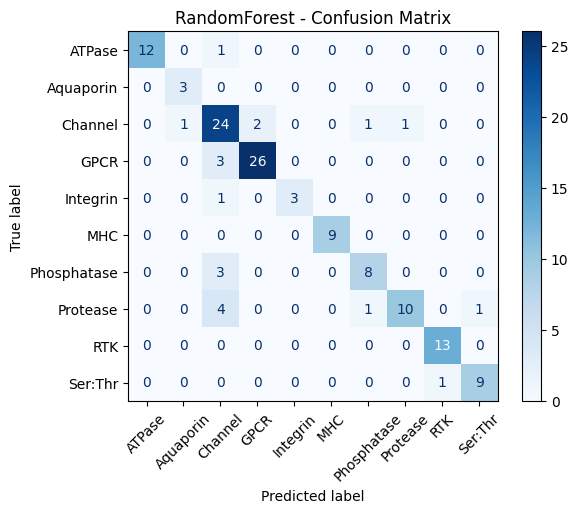

100%|===================| 1369/1370 [03:28<00:00]        

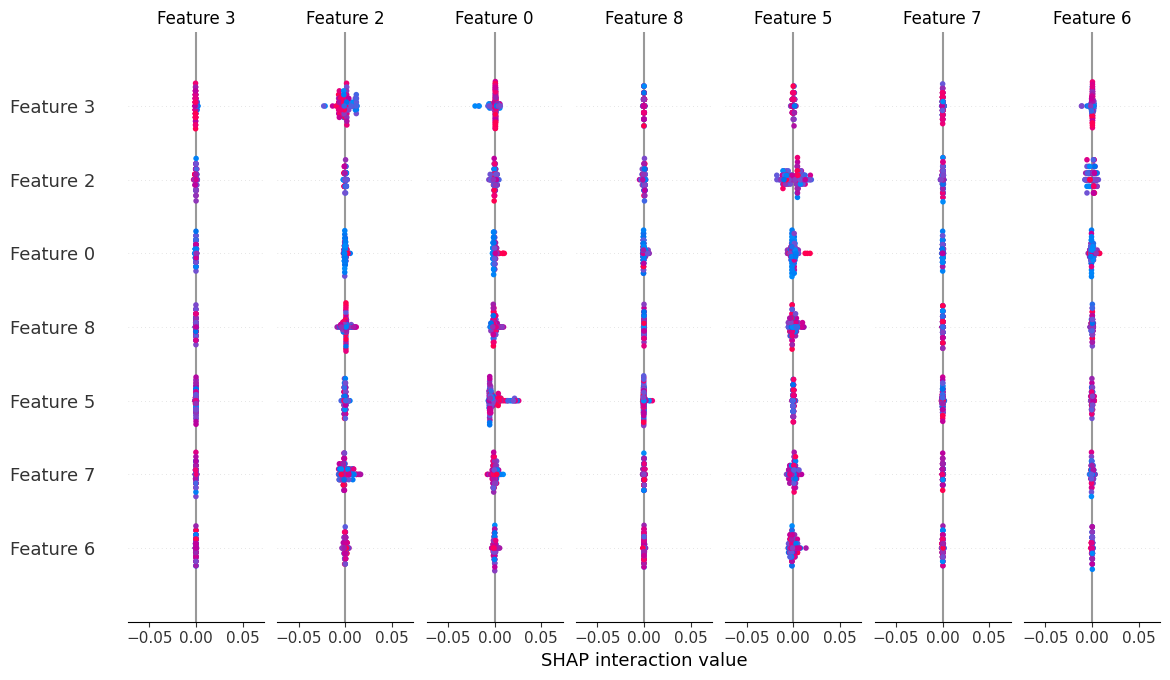


=== Evaluating XGBoost ===
Accuracy: 0.9270
Macro F1 Score: 0.9359


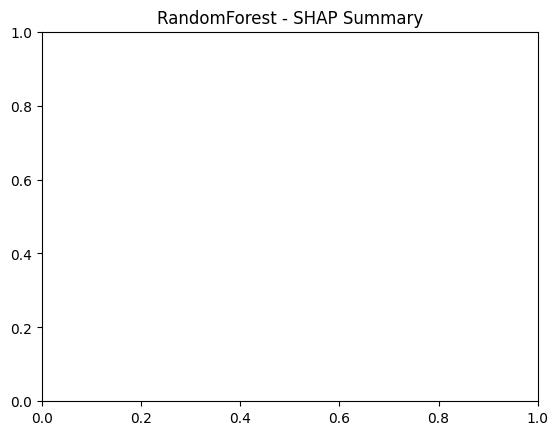

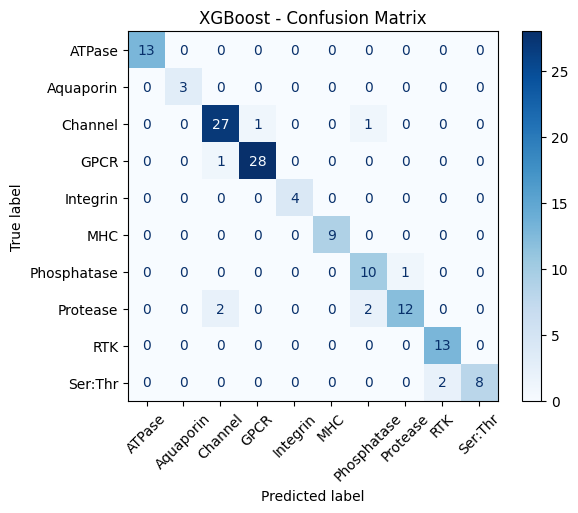

 99%|===================| 1361/1370 [06:06<00:02]        

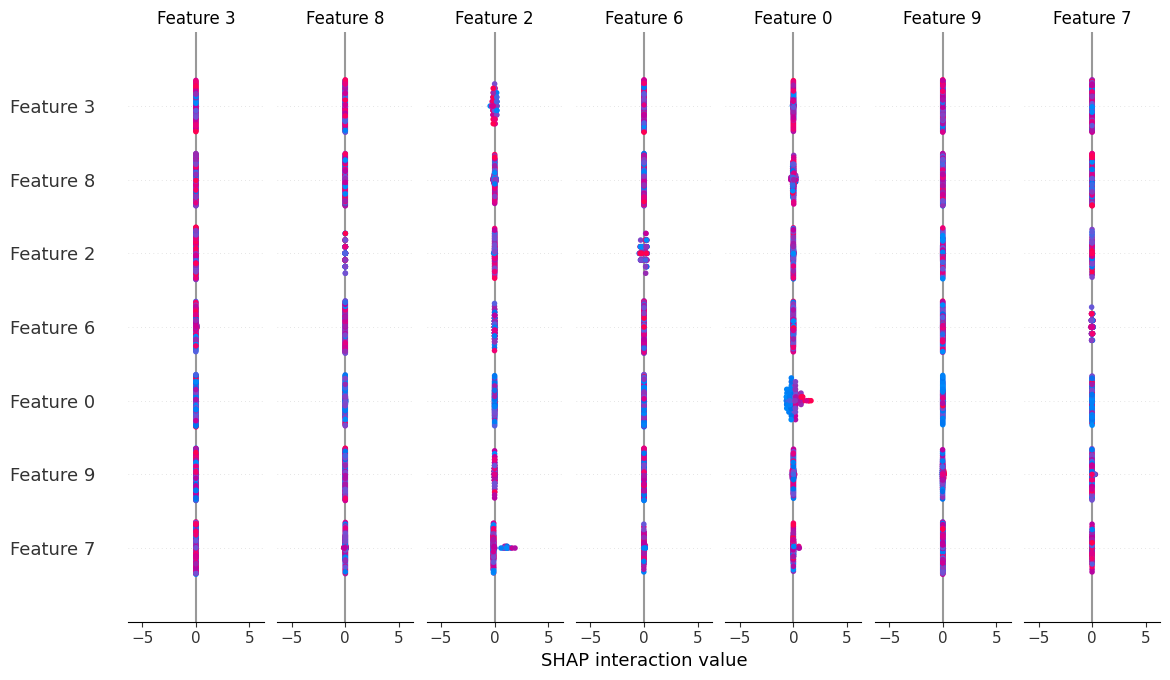


=== Evaluating SVC ===
Accuracy: 0.9343
Macro F1 Score: 0.9308


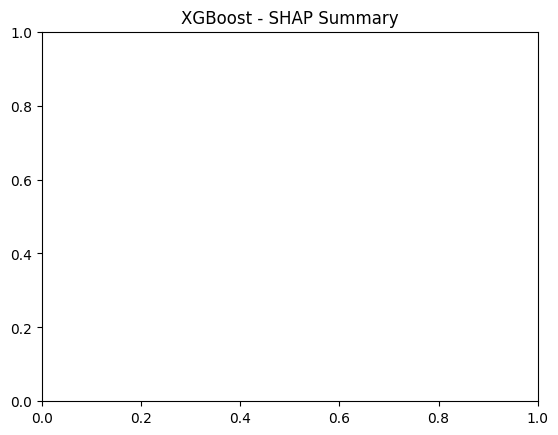

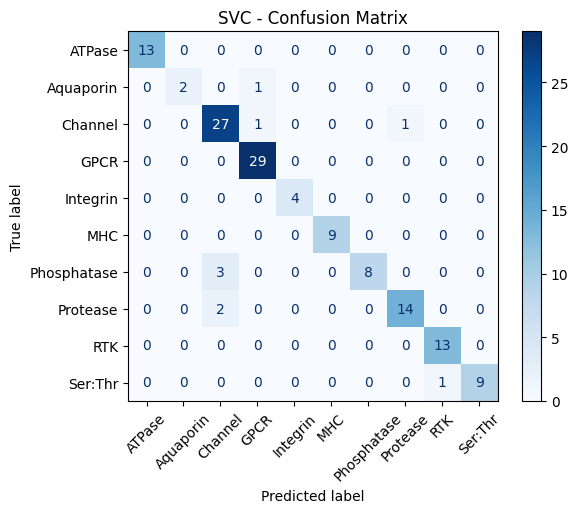

SHAP error for SVC: The passed model is not callable and cannot be analyzed directly with the given masker! Model: SVC(C=6.5950934726803165, gamma='auto', probability=True, random_state=42)

=== Evaluating LogReg ===
Accuracy: 0.9708
Macro F1 Score: 0.9754


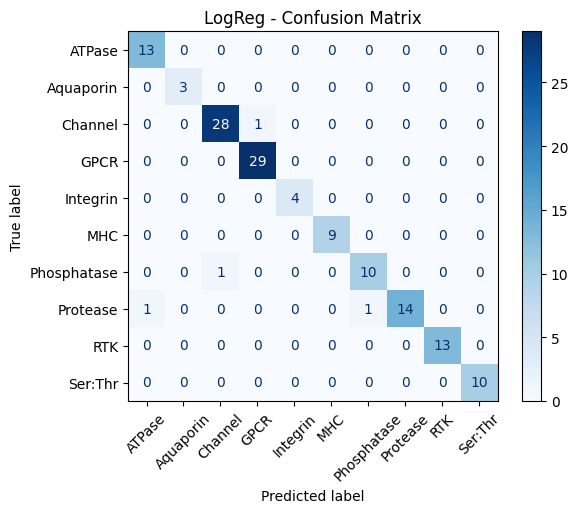

SHAP error for LogReg: only integer scalar arrays can be converted to a scalar index

=== EVALUATING ADVANCED MODELS ===

=== Evaluating RandomForest ===
Accuracy: 0.8540
Macro F1 Score: 0.8691


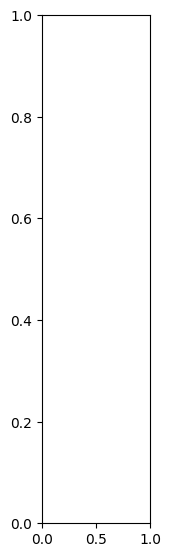

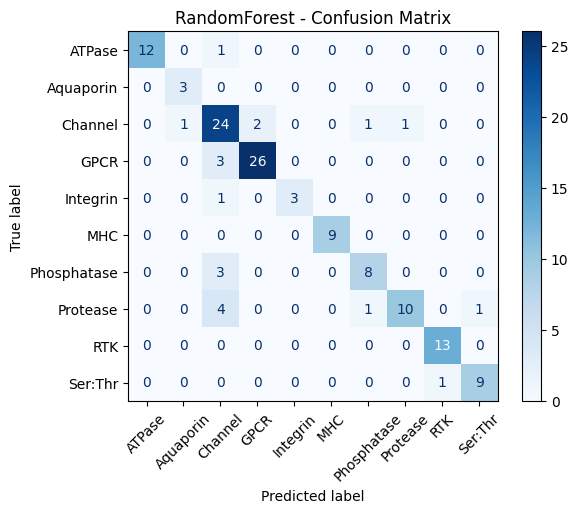

 99%|===================| 1360/1370 [03:42<00:01]        

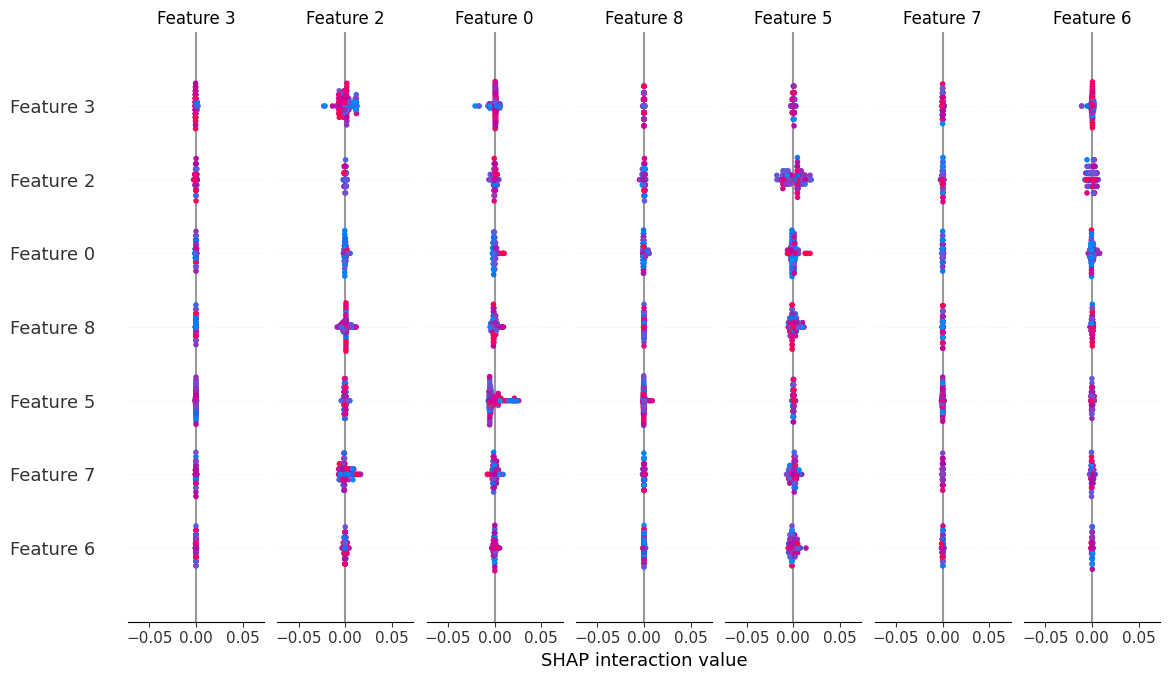


=== Evaluating XGBoost ===
Accuracy: 0.9270
Macro F1 Score: 0.9359


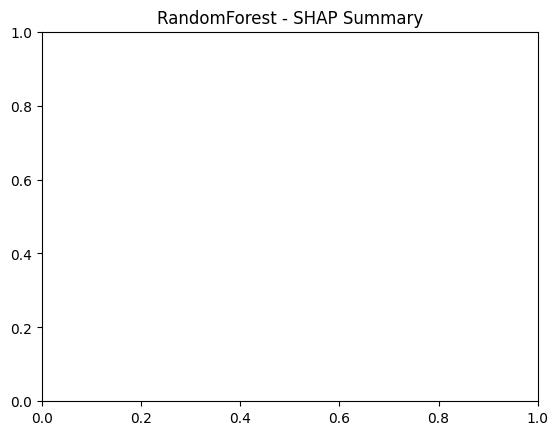

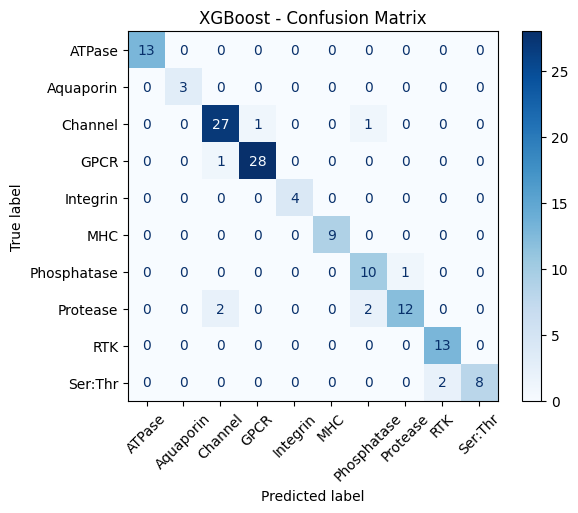

100%|===================| 1366/1370 [02:08<00:00]        

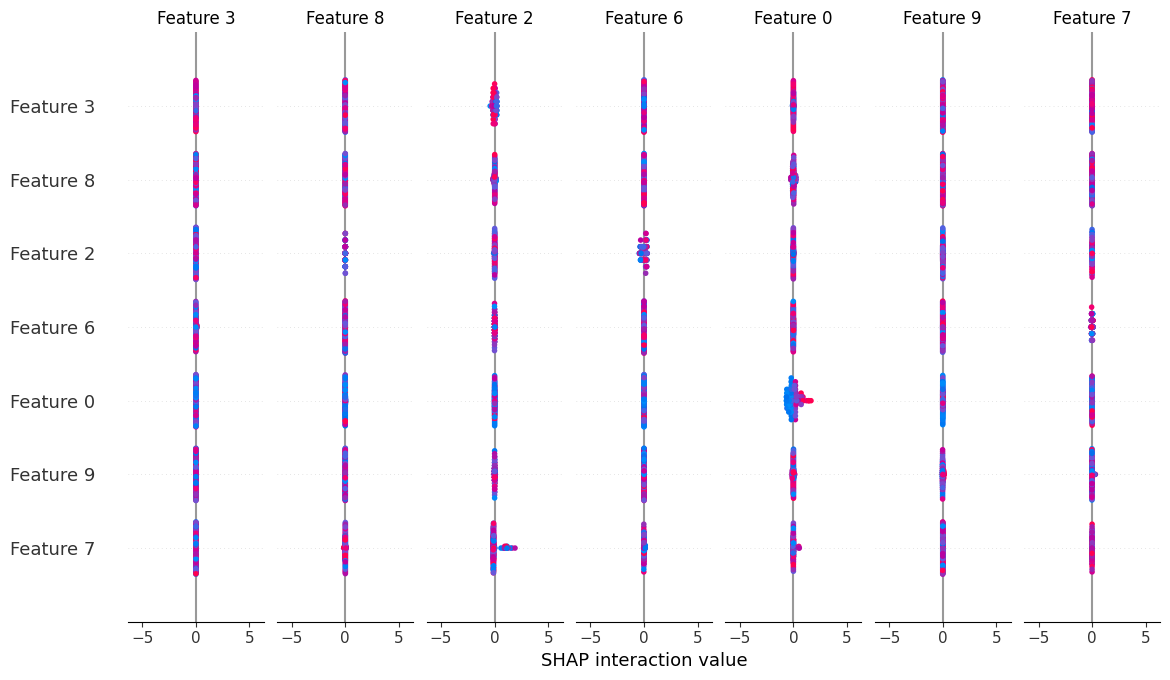


=== Evaluating SVC ===
Accuracy: 0.9343
Macro F1 Score: 0.9308


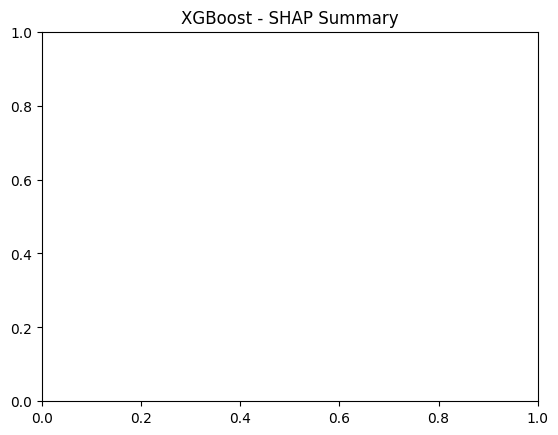

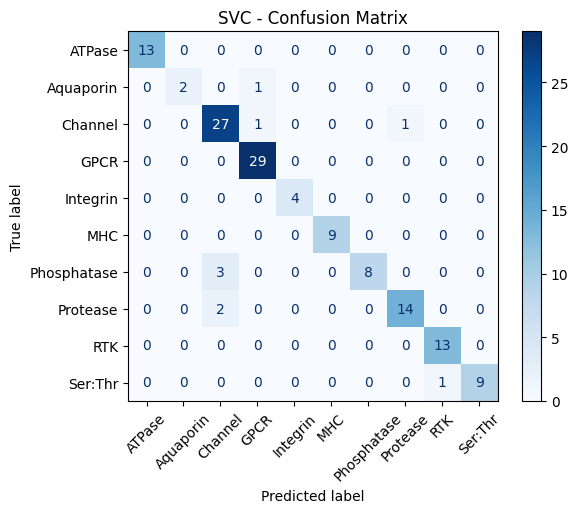

SHAP error for SVC: The passed model is not callable and cannot be analyzed directly with the given masker! Model: SVC(C=6.5950934726803165, gamma='auto', probability=True, random_state=42)

=== Evaluating LogReg ===
Accuracy: 0.9708
Macro F1 Score: 0.9754


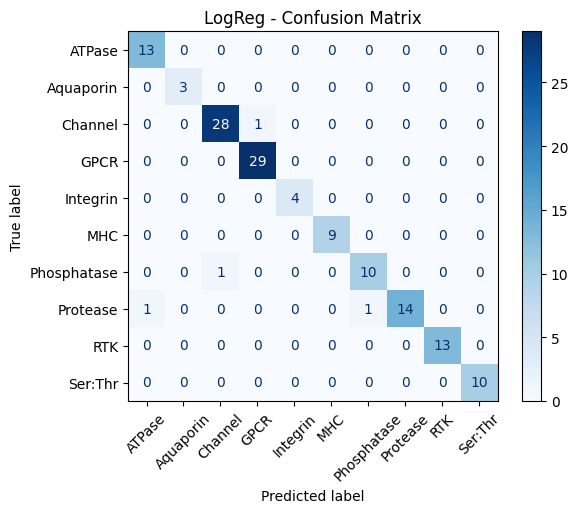

SHAP error for LogReg: only integer scalar arrays can be converted to a scalar index


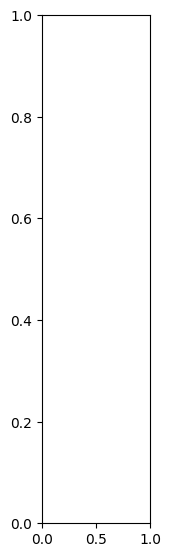

In [38]:
# Evaluate all models on BASIC
print("\n=== EVALUATING BASIC MODELS ===")
for name, model in basic_models.items():
    evaluate_model_full(model, X_test_basic, y_test_basic, model_name=name, label_encoder=label_encoder)

# Evaluate all models on ADVANCED
print("\n=== EVALUATING ADVANCED MODELS ===")
for name, model in advanced_models.items():
    evaluate_model_full(model, X_test_advanced, y_test_advanced, model_name=name, label_encoder=label_encoder)


# 10-fold CV evaluation of a classifier

### Question 5: Cross Validation

**• What is the point? List pros and cons of such approaches? Look into approaches and write a paragraph with citations of potential approaches.**

Cross-validation is a fundamental model evaluation strategy that estimates the generalization performance of machine learning models by systematically partitioning the training data into multiple folds. The most widely used variant is **k-fold cross-validation**, which splits the data into _k_ subsets (folds), trains the model on _k − 1_ of them, and tests on the remaining fold. This process is repeated _k_ times so that each fold serves as the test set once, and the final performance is averaged over all folds to yield a robust estimate. The primary advantage of cross-validation is that it reduces the variance of model evaluation metrics by minimizing reliance on a single random split, which is especially important in small or imbalanced biological datasets such as those used in protein classification tasks [12]. **Stratified k-fold** extends this idea by ensuring class proportions remain consistent across all folds, improving evaluation reliability in multi-class problems or datasets with rare functional classes [24].

A key benefit of cross-validation is its ability to detect overfitting and model instability across different partitions of the data. It is particularly useful when combined with **grid search** or **randomized search** for hyperparameter tuning, allowing practitioners to find optimal configurations based on average validation performance rather than a single holdout score [15]. Additionally, cross-validation supports model comparison by standardizing evaluation conditions, making it easier to benchmark algorithms such as logistic regression, SVMs, and random forests on an equal footing [12].

Despite its strengths, cross-validation also has limitations. Its primary drawback is **computational cost**, especially when used with large datasets, deep learning models, or exhaustive hyperparameter grids. This cost scales linearly with _k_ and the number of parameter combinations, making **nested cross-validation**—used for both hyperparameter tuning and model assessment—particularly expensive [13]. Another limitation is the **variance in performance across folds**, which may still arise in datasets with clustered or non-iid structures. When not properly accounted for, this can lead to misleading performance estimates or model selection based on fold-specific artifacts. Nevertheless, techniques such as **repeated stratified k-fold** help mitigate this by repeating the cross-validation procedure multiple times with different fold assignments, providing a more stable estimate of model generalization.

In protein classification, where class distributions are often skewed, biologically meaningful signals are sparse, and data scarcity is a concern, cross-validation offers a statistically principled and reproducible mechanism for evaluating classifier robustness, tuning hyperparameters, and safeguarding against overfitting [12, 15, 24].


In [ ]:
# 10-fold CV evaluation of a classifier
def eval_clf(_clf, _X, _y):
    model_cv = cross_validate(_clf, _X, _y, cv=10, scoring='accuracy', n_jobs=10, return_estimator=True)
    return model_cv

def evaluate_model_CV(model, X, y, model_name):

    model_cv = eval_clf(model, X, y)
    acc = model_cv["test_score"]

    # Evaluation
    print(f"\n=== {model_name} ===")
    print(f'CV accuracy: {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
    return model_cv["estimator"]

In [ ]:
# 10-Fold CV of my model
#my_model_cv= evaluate_model_CV(random_model(), X, y_label_encoded, "My Random Model CV")

# 10-Fold CV of Logistic Regression
#LR_model_cv = evaluate_model_CV(LogisticRegression(), X_scaled, y, "Logistic Regression CV")

## To Do ##
# Perform CV for all your three models

/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning:


=== My Random Model CV ===
CV accuracy: nan ±nan

=== Logistic Regression CV ===
CV accuracy: 0.74 ±0.024


In [43]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# === Extract X and y from Basic dataset ===
df = Dataset_basic.copy()
X = df.drop(columns=["ProteinClass"]).values
y = df["ProteinClass"].values

# === Scale X and Encode y ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# === CV function definitions ===
def eval_clf(_clf, _X, _y):
    model_cv = cross_validate(_clf, _X, _y, cv=10, scoring='accuracy', n_jobs=10, return_estimator=True)
    return model_cv

def evaluate_model_CV(model, X, y, model_name):
    try:
        model_cv = eval_clf(model, X, y)
        acc = model_cv["test_score"]
        print(f"\n=== {model_name} ===")
        print(f'CV accuracy: {np.mean(acc):.4f} ± {np.std(acc):.4f}')
        return model_cv["estimator"]
    except Exception as e:
        print(f"[ERROR] CV failed for {model_name}: {e}")
        return []

# === Run 10-fold CV for all models on BASIC dataset ===
my_model_cv = evaluate_model_CV(random_model(), X_scaled, y_encoded, "My Random Model CV")
lr_model_cv = evaluate_model_CV(LogisticRegression(max_iter=1000), X_scaled, y_encoded, "Logistic Regression CV")
rf_model_cv = evaluate_model_CV(RandomForestClassifier(random_state=42, n_jobs=-1), X_scaled, y_encoded, "Random Forest CV")
xgb_model_cv = evaluate_model_CV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1), X_scaled, y_encoded, "XGBoost CV")
svc_model_cv = evaluate_model_CV(SVC(probability=True, random_state=42), X_scaled, y_encoded, "SVC CV")


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning:


=== My Random Model CV ===
CV accuracy: 0.1087 ± 0.0209

=== Logistic Regression CV ===
CV accuracy: 0.7415 ± 0.0242

=== Random Forest CV ===
CV accuracy: 0.7739 ± 0.0316


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not


=== XGBoost CV ===
CV accuracy: 0.7666 ± 0.0315

=== SVC CV ===
CV accuracy: 0.7827 ± 0.0356


# Creating Ensemble Model

### Question 6: Ensemble Section

**• Why are smaller weak learners potentially a good idea? How do you determine the optimal way to combine predictions from different models in an ensemble, and what challenges arise when trying to balance diversity and accuracy among the models? Look into approaches and write a paragraph with citations of potential approaches.**  

Weak learners—models that perform only slightly better than random chance—are foundational components in ensemble learning due to their capacity to capture distinct local patterns in the feature space with minimal complexity. Examples include decision stumps, shallow trees, or sparse linear models, which are intentionally underfit and thus prone to high bias. However, when integrated across many instances through ensemble mechanisms, these learners can complement one another and form a powerful, low-bias, low-variance classifier. In boosting algorithms, for instance, weak learners are trained sequentially such that each new learner focuses on correcting the residual errors of its predecessors, enabling the ensemble to model complex decision boundaries even when each base learner is limited in expressivity【13】. This process is especially advantageous in biological settings, where local motifs or subtle sequence features (e.g., rare functional domains) may not be adequately captured by a single monolithic model.

The effectiveness of an ensemble is not solely determined by the individual performance of its components, but rather by the **diversity and independence** of their error patterns. If all models make similar mistakes, ensemble aggregation provides little benefit. Therefore, strategies such as **bootstrap sampling** (bagging), **feature subsampling** (as in Random Forests), or constructing ensembles from heterogeneous model types (e.g., combining SVMs, k-NNs, and tree-based learners) are employed to promote variation among learners【15, 27, 28】. This diversity ensures that different models explore orthogonal hypotheses about the underlying structure of the data, allowing the final ensemble to correct for individual weaknesses. However, increased diversity often comes at the cost of reduced individual accuracy, creating a tradeoff that must be optimized.

To determine the **optimal combination strategy**, several techniques are available. **Voting-based approaches** (e.g., majority voting or weighted voting) aggregate discrete predictions, while **probabilistic averaging** combines class probabilities. **Stacked generalization** (stacking) uses the outputs of base learners as inputs to a meta-learner, which learns to optimally weight or combine predictions based on performance patterns observed during cross-validation【29】. In protein classification, stacking has been shown to improve performance when base learners are trained on different types of descriptors (e.g., amino acid composition, physicochemical properties, structural embeddings), as each may offer unique perspectives on functional discrimination【5, 9】.

Despite these advantages, **ensemble learning introduces practical challenges**. First, ensembles are often less interpretable than single models, especially when comprising dozens or hundreds of base learners. In biomedical domains where explainability is paramount, this opacity limits clinical or biological adoption. To mitigate this, **interpretability frameworks such as SHAP (SHapley Additive exPlanations)** can be used to decompose the final prediction into additive contributions of each feature across the ensemble, allowing feature attribution analysis even in complex models【16】. Second, computational overhead increases linearly with the number of models, complicating deployment and real-time inference. Finally, ensembles may propagate data leakage or bias if improperly cross-validated, particularly in small or imbalanced datasets. These risks necessitate rigorous cross-validation protocols and careful monitoring of model diversity and generalization behavior【12, 29】.

In summary, smaller weak learners are valuable in ensemble systems because they provide complementary views of the data, especially when biological features are noisy, redundant, or high-dimensional. Their integration through ensemble strategies improves generalization and robustness. However, achieving a balance between diversity and accuracy requires deliberate ensemble construction, appropriate model selection, and interpretability frameworks to ensure that performance gains are biologically meaningful and practically usable in real-world protein classification tasks.

In [52]:
y_label_encoded = label_encoder.transform(y)


In [56]:
N_ENSEMBLE = 100

# Initialize my ensuble model
clfs_my_model = [random_model() for _ in range(N_ENSEMBLE)]
clfs_lr_model = [LogisticRegression() for _ in range(N_ENSEMBLE)]

## To Do ##
# Create one Ensemble model
# Number of classifiers in the ensemble

clfs_rf_model = [RandomForestClassifier(n_jobs=-1, random_state=i) for i in range(N_ENSEMBLE)]
clfs_xgb_model = [XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='hist', n_jobs=-1, random_state=i) for i in range(N_ENSEMBLE)]



# Ensemble Helper Functions

In [61]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_validate
import numpy as np
import random

# === Wrapper for Ensemble Voting Classifier ===
class Eclf(BaseEstimator):
    def __init__(self, ensemble=None, subsample_ratio=0.1):
        # Initialize with a list of classifiers and a subsample ratio
        self.ensemble = ensemble if ensemble is not None else []
        self.sr = subsample_ratio

    def fit(self, _X, _y):
        # Store number of unique classes for use in prediction
        self.unique_classes = len(np.unique(_y))
        N = _X.shape[0]

        # Train each classifier on a stratified subsample of the training data
        for c in self.ensemble:
            bCheck = True
            while bCheck:
                ix = random.sample(range(N), int(self.sr * N))
                if len(np.unique(_y[ix])) == self.unique_classes:
                    bCheck = False
            c.fit(_X[ix, :], _y[ix])
        return self

    def predict(self, _X):
        # Predict class probabilities and vote across the ensemble
        N = _X.shape[0]
        ypred_scores = np.zeros((N, self.unique_classes))
        for c in self.ensemble:
            pred = c.predict_proba(_X)
            for i in range(N):
                ypred_scores[i] += pred[i]
        ypred = np.argmax(ypred_scores, axis=1)
        return ypred

    def get_params(self, deep=True):
        return {'ensemble': self.ensemble, 'subsample_ratio': self.sr}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# === Cross-Validation Wrapper for Ensemble Evaluation ===
def eval_ensemble_clf(_ensemble_list, _X, _y, _subsample_ratio=0.1):
    # Wrap the ensemble into Eclf and run 10-fold cross-validation
    model = Eclf(ensemble=_ensemble_list, subsample_ratio=_subsample_ratio)
    my_cv_model_ensemble = cross_validate(
        model,
        _X,
        _y,
        cv=10,
        scoring='accuracy',
        n_jobs=10,
        return_estimator=True
    )
    return my_cv_model_ensemble


# Ensemble Traning and Evaluation 

In [62]:
# Evaluate ensemble
def evaluate_model_CV_ensemble(model_ensemble, X, y, model_name, subsample_ratio):

    model_cv_ensemble = eval_ensemble_clf(model_ensemble, X, y, _subsample_ratio=subsample_ratio)
    acc = model_cv_ensemble["test_score"]

    # Evaluation
    print(f"\n=== {model_name} ===")
    print(f'Ensemble CV accuracy: {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
    return model_cv_ensemble["estimator"]

In [63]:
# Ensemble traning and evaluation 
clfs_lr_model_ensemble = evaluate_model_CV_ensemble(clfs_lr_model, X_scaled, y_label_encoded,'Logistic Regression CV Ensemble', subsample_ratio=0.6)


## To Do ##
# Train and Evaluate one of your Ensemble models
# Train and Evaluate Random Forest Ensemble
clfs_rf_model_ensemble = evaluate_model_CV_ensemble(
    clfs_rf_model,
    X_scaled,
    y_label_encoded,
    model_name='Random Forest CV Ensemble',
    subsample_ratio=0.6
)

# Train and Evaluate XGBoost Ensemble
clfs_xgb_model_ensemble = evaluate_model_CV_ensemble(
    clfs_xgb_model,
    X_scaled,
    y_label_encoded,
    model_name='XGBoost CV Ensemble',
    subsample_ratio=0.6
)


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning:


=== Logistic Regression CV Ensemble ===
Ensemble CV accuracy: 0.77 ±0.028

=== Random Forest CV Ensemble ===
Ensemble CV accuracy: 0.76 ±0.029


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:09:09] WARNING: 


=== XGBoost CV Ensemble ===
Ensemble CV accuracy: 0.78 ±0.029


In [64]:
# This code is provided if you want more control of your Cross Validation
def ensemble_fit(_clfs, _X, _y, subsample_ratio, unique_classes):
    N = _X.shape[0]
    for c in _clfs:
        bCheck = True # Check if we got two classes - especially problem for very small subsample
        while bCheck:
            ix = random.sample(range(N), int(subsample_ratio*N))
            if len(np.unique(_y[ix])) ==unique_classes:
                bCheck = False
        c.fit(_X[ix,:], _y[ix])

def ensemble_predict(_clfs, _X, unique_classes):
    N = _X.shape[0]
    ypred_scores = np.zeros((N, unique_classes))
    for c in _clfs:
        pred = c.predict_proba(_X)
        for i in range(N):
            ypred_scores[i] += pred[i]
        ypred = np.argmax(ypred_scores, axis=1)
    return ypred

# 10-fold CV evaluation of a classifier, using an ensemble
def eval_ensemble_clf_trivial(_ensemble_list, _X, _y, _subsample_ratio):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False)
    unique_classes = len(np.unique(_y))
    for tr_i, ts_i in kf.split(_X, _y):
        ensemble_fit(_ensemble_list, _X[tr_i], _y[tr_i], _subsample_ratio, unique_classes)
        y_pred = ensemble_predict(_ensemble_list, _X[ts_i], unique_classes)
        acc += [accuracy_score(_y[ts_i], y_pred)]
    return acc # return list

In [65]:
# Train and Evaluate Ensemble model for the travial 
acc = eval_ensemble_clf_trivial(clfs_lr_model, X_scaled, y_label_encoded, 0.1)
print(f'Ensemble LR accuracy: {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

# Logistic Regression Ensemble (Trivial CV)
acc_lr = eval_ensemble_clf_trivial(clfs_lr_model, X_scaled, y_label_encoded, 0.1)
print(f'Ensemble LR accuracy: {np.mean(acc_lr):.2f} {chr(177)}{np.std(acc_lr):.3f}')

# Random Forest Ensemble (Trivial CV)
acc_rf = eval_ensemble_clf_trivial(clfs_rf_model, X_scaled, y_label_encoded, 0.1)
print(f'Ensemble RF accuracy: {np.mean(acc_rf):.2f} {chr(177)}{np.std(acc_rf):.3f}')

# XGBoost Ensemble (Trivial CV)
acc_xgb = eval_ensemble_clf_trivial(clfs_xgb_model, X_scaled, y_label_encoded, 0.1)
print(f'Ensemble XGB accuracy: {np.mean(acc_xgb):.2f} {chr(177)}{np.std(acc_xgb):.3f}')



Ensemble LR accuracy: 0.70 ±0.033
Ensemble LR accuracy: 0.71 ±0.028
Ensemble RF accuracy: 0.62 ±0.029


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:47:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:48:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:50:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:51:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Ensemble XGB accuracy: 0.70 ±0.030


# Save Format

In [66]:
def save_predictions(_fn, _y_pred, _df):
    import csv
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['Entry', 'ProteinClass'])
        for y, Entry in zip(_df['Entry'], _y_pred):
            writer.writerow([y, Entry])

In [70]:
print(Dataset_advanced.columns)


Index(['ProteinClass', 'SequenceLength', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
       'I',
       ...
       'AAIndex1_2', 'AAIndex1_148', 'AAIndex1_383', 'AAIndex1_197', 'CTDC_9',
       'AAIndex1_146', 'AAIndex1_478', 'AAIndex1_243', 'CTDT_15',
       'AAIndex1_437'],
      dtype='object', length=1239)


In [73]:
import csv

# Step 1: Add 'Entry' from index if not already present
Dataset_advanced['Entry'] = Dataset_advanced.index

# Step 2: Update save_predictions function
def save_predictions(_fn: str, _y_pred: np.ndarray, _df: pd.DataFrame) -> None:
    """
    Save the ensemble prediction results to a CSV file.
    If 'Entry' column does not exist, the index is used instead.

    Args:
        _fn: Filename to save the predictions to.
        _y_pred: Array of predicted class labels.
        _df: DataFrame from which to extract Entry identifiers.
    """
    try:
        # Use index if 'Entry' column not found
        entries = _df['Entry'] if 'Entry' in _df.columns else _df.index

        # Write predictions
        with open(_fn, 'w') as fout:
            writer = csv.writer(fout, delimiter=',', lineterminator='\n')
            writer.writerow(['Entry', 'ProteinClass'])  # Header row
            for entry, pred in zip(entries, _y_pred):
                writer.writerow([entry, pred])
    except Exception as e:
        print(f"[ERROR] Failed to save predictions to {_fn}: {e}")

# Recompute missing predictions
y_pred_rf = ensemble_predict(clfs_rf_model, X_scaled, len(np.unique(y_label_encoded)))
y_pred_rf_labels = label_encoder.inverse_transform(y_pred_rf)

y_pred_xgb = ensemble_predict(clfs_xgb_model, X_scaled, len(np.unique(y_label_encoded)))
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Now re-run the save functions
save_predictions("ensemble_output/ensemble_logistic_regression.csv", y_pred_lr_labels, Dataset_advanced)
save_predictions("ensemble_output/ensemble_random_forest.csv", y_pred_rf_labels, Dataset_advanced)
save_predictions("ensemble_output/ensemble_xgboost.csv", y_pred_xgb_labels, Dataset_advanced)

print(" All ensemble predictions successfully saved.")



[✅] All ensemble predictions successfully saved.


### References

1. Ackerman-Schraier, L., Rosenberg, A. A., Marx, A., & Bronstein, A. M. (2022). Machine learning approaches demonstrate that protein structures carry information about their genetic coding. *Scientific Reports, 12*(1), 21968. https://doi.org/10.1038/s41598-022-25874-z

2. AlQuraishi, M., & Sorger, P. K. (2021). Differentiable biology: using deep learning for biophysics-based and data-driven modeling of molecular mechanisms. *Nature Methods, 18*(10), 1169–1180. https://doi.org/10.1038/s41592-021-01283-4

3. Ashrafzadeh, S., Golding, G. B., Ilie, S., & Ilie, L. (2024). Scoring alignments by embedding vector similarity. *Briefings in Bioinformatics, 25*(3), bbae178. https://doi.org/10.1093/bib/bbae178

4. Bepler, T., & Berger, B. (2021). Learning the protein language: Evolution, structure, and function. *Cell Systems, 12*(6), 654–669.e3. https://doi.org/10.1016/j.cels.2021.05.017

5. Biswas, S., Khimulya, G., Alley, E. C., Esvelt, K. M., & Church, G. M. (2021). Low-N protein engineering with data-efficient deep learning. *Nature Methods, 18*, 389–396. https://doi.org/10.1038/s41592-021-01100-y

6. Boadu, F., Cao, H., & Cheng, J. (2023). Combining protein sequences and structures with transformers and equivariant graph neural networks to predict protein function. *Bioinformatics, 39*(Suppl 1), i318–i325. https://doi.org/10.1093/bioinformatics/btad208

7. Bordin, N., Dallago, C., Heinzinger, M., Kim, S., Littmann, M., Rauer, C., Steinegger, M., Rost, B., & Orengo, C. (2023). Novel machine learning approaches revolutionize protein knowledge. *Trends in Biochemical Sciences, 48*(4), 345–359. https://doi.org/10.1016/j.tibs.2022.11.001

8. Bugnon, L. A., Fenoy, E., Edera, A. A., Raad, J., Stegmayer, G., & Milone, D. H. (2023). Transfer learning: The key to functionally annotate the protein universe. *Patterns, 4*(2), 100691. https://doi.org/10.1016/j.patter.2023.100691

9. Chen, Z., Liu, X., Zhao, P., Li, C., Wang, Y., Li, F., Akutsu, T., Bain, C., Gasser, R. B., Li, J., Yang, Z., Gao, X., Kurgan, L., & Song, J. (2022). iFeatureOmega: an integrative platform for engineering, visualization and analysis of features from molecular sequences, structural and ligand data sets. *Nucleic Acids Research, 50*(W1), W434–W447. https://doi.org/10.1093/nar/gkac351

10. Das, S., & Chakrabarti, S. (2021). Classification and prediction of protein-protein interaction interface using machine learning algorithm. *Scientific Reports, 11*(1), 1761. https://doi.org/10.1038/s41598-020-80900-2

11. Detlefsen, N. S., Hauberg, S., & Boomsma, W. (2022). Learning meaningful representations of protein sequences. *Nature Communications, 13*, 1914. https://doi.org/10.1038/s41467-022-29443-w

12. Ektefaie, Y., Shen, A., Bykova, D., Ma, T., Snyder, M. P., & Zou, J. (2024). Evaluating generalizability of artificial intelligence models for molecular datasets. *Nature Machine Intelligence, 6*, 1512–1524. https://doi.org/10.1038/s42256-024-00931-6

13. Gao, W., Mahajan, S. P., Sulam, J., & Gray, J. J. (2020). Deep learning in protein structural modeling and design. *Patterns, 1*(9), 100142. https://doi.org/10.1016/j.patter.2020.100142

14. Gligorijević, V., Renfrew, P. D., Kosciolek, T., Leman, J. K., Berenberg, D., Vatanen, T., Chandler, C., Taylor, B. C., Fisk, I. M., Vlamakis, H., Xavier, R. J., Knight, R., Cho, K., & Bonneau, R. (2021). Structure-based protein function prediction using graph convolutional networks. *Nature Communications, 12*(1), 3168. https://doi.org/10.1038/s41467-021-23303-9

15. Jung, S. G., Jung, G., & Cole, J. M. (2025). Automatic prediction of molecular properties using substructure vector embeddings within a feature selection workflow. *Journal of Chemical Information and Modeling, 65*(1), 133–152. https://doi.org/10.1021/acs.jcim.4c01862

16. Kha, Q. H., Tran, T. O., Nguyen, T. T., Nguyen, V. N., Than, K., & Le, N. Q. K. (2022). An interpretable deep learning model for classifying adaptor protein complexes from sequence information. Methods (San Diego, Calif.), 207, 90–96. https://doi.org/10.1016/j.ymeth.2022.09.007

17. Lai, B., & Xu, J. (2022). Accurate protein function prediction via graph attention networks with predicted structure information. *Briefings in Bioinformatics, 23*(1), bbab502. https://doi.org/10.1093/bib/bbab502

18. Lin, Z., Akin, H., Rao, R., Hie, B., Zhu, Z., Lu, W., Smetanin, N., Verkuil, R., Kabeli, O., Shmueli, Y., Dos Santos Costa, A., Fazel-Zarandi, M., Sercu, T., Candido, S., & Rives, A. (2023). Evolutionary-scale prediction of atomic-level protein structure with a language model. *Science, 379*(6637), 1123–1130. https://doi.org/10.1126/science.ade2574

19. Ma, W., Zhang, S., Li, Z., Jiang, M., Wang, S., Lu, W., Bi, X., Jiang, H., Zhang, H., & Wei, Z. (2022). Enhancing protein function prediction performance by utilizing AlphaFold-predicted protein structures. *Journal of Chemical Information and Modeling, 62*(17), 4008–4017. https://doi.org/10.1021/acs.jcim.2c00885

20. Ofer, D., & Linial, M. (2015). ProFET: Feature engineering captures high-level protein functions. *Bioinformatics, 31*(21), 3429–3436. https://doi.org/10.1093/bioinformatics/btv345

21. Renaud, N., Geng, C., Georgievska, S., Ambrosetti, F., Ridder, L., Marzella, D. F., Réau, M. F., Bonvin, A. M. J. J., & Xue, L. C. (2021). DeepRank: A deep learning framework for data mining 3D protein-protein interfaces. *Nature Communications, 12*, 7068. https://doi.org/10.1038/s41467-021-27396-0

22. Rives, A., Meier, J., Sercu, T., Goyal, S., Lin, Z., Liu, J., Guo, D., Ott, M., Zitnick, C. L., Ma, J., & Fergus, R. (2021). Biological structure and function emerge from scaling unsupervised learning to 250 million protein sequences. *Proceedings of the National Academy of Sciences, 118*(15), e2016239118. https://doi.org/10.1073/pnas.2016239118

23. Romero, P. A., Krause, A., & Arnold, F. H. (2013). Navigating the protein fitness landscape with Gaussian processes. *Proceedings of the National Academy of Sciences, 110*(3), E193–E201. https://doi.org/10.1073/pnas.1215251110

24. Sargsyan, K., & Lim, C. (2024). Using protein language models for protein interaction hot spot prediction with limited data. *BMC Bioinformatics, 25*(1), 115. https://doi.org/10.1186/s12859-024-05737-2

25. Unsal, S., Atas, H., Albayrak, M., Karakulak, T., Durmaz, A., Turhan, K., Inan, M. S., & Ozturk, A. R. (2022). Learning functional properties of proteins with language models. *Nature Machine Intelligence, 4*, 227–245. https://doi.org/10.1038/s42256-022-00457-9

26. Vargas, S., Chaturvedi, S. S., & Alexandrova, A. N. (2024). Machine-learning prediction of protein function from the portrait of its intramolecular electric field. *Journal of the American Chemical Society*. Advance online publication. https://doi.org/10.1021/jacs.4c09549

27. Wan, C., & Jones, D. T. (2020). Protein function prediction is improved by creating synthetic feature samples with generative adversarial networks. *Nature Machine Intelligence, 2*, 540–550. https://doi.org/10.1038/s42256-020-0222-1

28. Wild, R., Wodaczek, F., Del Tatto, V., Cheng, B., & Laio, A. (2025). Automatic feature selection and weighting in molecular systems using Differentiable Information Imbalance. *Nature Communications, 16*(1), 270. https://doi.org/10.1038/s41467-024-55449-7

29. Wittmann, B. J., Yue, Y., & Arnold, F. H. (2021). Informed training set design enables efficient machine learning-assisted directed protein evolution. *Cell Systems, 12*(11), 1026–1045.e7. https://doi.org/10.1016/j.cels.2021.07.008

30. Yuan, Q., Xie, J., Xie, J., Zhao, H., & Yang, Y. (2023). Fast and accurate protein function prediction from sequence through pretrained language model and homology-based label diffusion. *Briefings in Bioinformatics, 24*(3), bbad117. https://doi.org/10.1093/bib/bbad117

31. Zhou, Z., Zhang, L., Yu, Y., Wu, B., Li, M., Hong, L., & Tan, P. (2024). Enhancing efficiency of protein language models with minimal wet-lab data through few-shot learning. *Nature Communications, 15*(1), 5566. https://doi.org/10.1038/s41467-024-49798-6
